In [1]:
from rltensor.configs import eiie_config
from rltensor.agents import EIIE
import tensorflow as tf
import os
import pandas as pd
import pickle

from pytrade_env.runners import RLEnv

class Context:
    commission_rate = 2.5e-3
    price_keys = ['open', 'high', 'low']
    volume_keys = []
    initial_capital = 1.0


def train_model(start, end=None, load_file_path=None, save_file_path=None,
                num_epochs=int(2e6), agent_cls=EIIE,
                symbols_file="ticker1.pkl", record_actions_length=10):
    file = open(symbols_file, "rb")
    symbols = pickle.load(file)
    print("******************************symbols*********************")
    print(symbols)
    print("start", start, "end", end)
    context = Context()
    context.start = start
    context.end = end
    env = RLEnv(symbols, context)

    conf = dict(
        action_spec={"type": "float", "shape": env.action_dim},
        state_spec={"type": "float", "shape": (env.num_stocks, 3)}
    )

    default_config = eiie_config()
    conf.update(default_config)
    conf["symbols"] = symbols
    conf["record_actions_length"] = record_actions_length

    fit_config = dict(
        start=start,
        end=end,
        num_epochs=num_epochs,
        log_freq=1000,
    )

    if save_file_path is None:
        _start = start.split(" ")
        _start = "_".join(_start)
        if end is None:
            save_file_path = 'params{}/model.ckpt'.format(_start)
        else:
            save_file_path = 'params{}-{}/model.ckpt'.format(start, end)

    tf.reset_default_graph()
    agent = agent_cls(env=env, load_file_path=load_file_path, **conf)
    agent.fit(**fit_config, save_file_path=save_file_path)
    return agent

/home/tom/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
import pandas as pd

from pytrade_env.strategies import MovingAverageCrossStrategy
from pytrade_env.runners import Runner
from pytrade_env.portfolios import RatioPortfolio

class Context:
    commission_rate = 0.5
    price_keys = ['open', 'high', 'low']
    volume_keys = []
    initial_capital = 1.0


def backtest(start, end, strategy=MovingAverageCrossStrategy(), portfolio_cls=RatioPortfolio,
             symbols_file="ticker1.pkl", record_actions_length=10):
    file = open(symbols_file, "rb")
    symbols = pickle.load(file)
    print("******************************symbols*********************")
    print(symbols)
    print("start", start, "end", end)

    context = Context()
    context.start = start
    context.end = end
    runner = Runner(strategy, symbols, context, portfolio_cls=portfolio_cls)
    runner.run(start, end)
    return runner

AttributeError: 'NoneType' object has no attribute 'symbol_list'

In [3]:
# from rltensor.app.utils import train_model

training_start = '2016-01-01 00:00:00'
training_end = '2018-01-01 00:00:00'
load_file_path = 'params{}-{}/model.ckpt'.format(training_start, training_end)
load_file_path = None


model = train_model(training_start, training_end, load_file_path=load_file_path, num_epochs=int(1e5),
                   symbols_file="/home/tomoaki/work/pytrade_env/pytrade_env/data/ticker1.pkl")

******************************symbols*********************
['USDT_XRP', 'USDT_BCH', 'USDT_BTC', 'USDT_DASH', 'USDT_ETC', 'USDT_ETH', 'USDT_LTC', 'USDT_XMR', 'USDT_ZEC']
start 2016-01-01 00:00:00 end 2018-01-01 00:00:00
delete
Building tensorflow graph...
Finished building tensorflow graph, spent time: 0.4550466537475586
Model saved in file: params2016-01-01 00:00:00-2018-01-01 00:00:00/model.ckpt


44it [00:00, 431.78it/s]

start: 2016-01-01 00:30:00
end: 2018-01-01 00:00:00


35089it [01:29, 391.47it/s]
  0%|          | 0/100000 [00:00<?, ?it/s]

Finished storing data.


100%|██████████| 100000/100000 [11:17<00:00, 147.55it/s]

Model saved in file: params2016-01-01 00:00:00-2018-01-01 00:00:00/model.ckpt


In [4]:
from pytrade_env.strategies import AgentWrapper

strategy = AgentWrapper(model)
test_start = '2018-01-01 00:00:00'
test_end = None

runner = backtest(test_start, test_end, strategy=strategy,
         symbols_file="/home/tomoaki/work/pytrade_env/pytrade_env/data/ticker1.pkl")

******************************symbols*********************
['USDT_XRP', 'USDT_BCH', 'USDT_BTC', 'USDT_DASH', 'USDT_ETC', 'USDT_ETH', 'USDT_LTC', 'USDT_XMR', 'USDT_ZEC']
start 2018-01-01 00:00:00 end None


10it [00:00, 95.16it/s]

start: 2018-01-01 00:30:00
end: 2018-02-10 02:00:00


1925it [00:18, 101.69it/s]


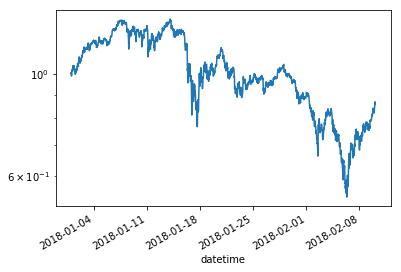

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

runner.equity_curve["total"].plot()
plt.yscale('log')

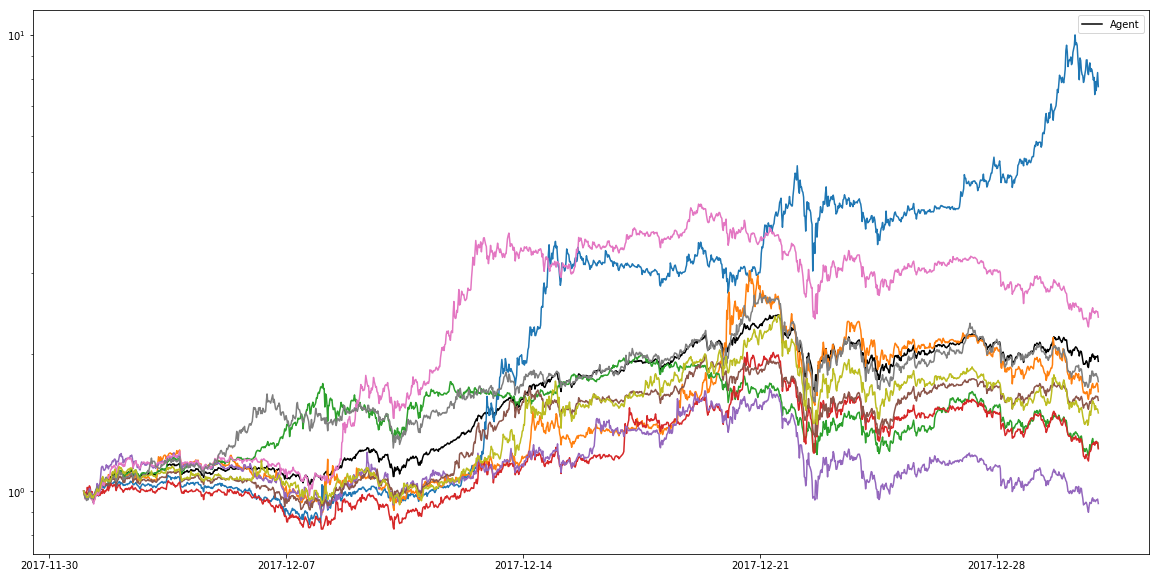

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df_ = runner.data_handler.col_data['open']

# df_ = df_.loc[(df_.index >= test_start) & (df_.index <=  test_end)]

test_start = '2017-12-01 00:00:00'
test_end = '2017-12-31 00:00:00'
# test_end  = get_time_now()
df = df_.loc[(df_.index >= test_start) & (df_.index <=  test_end)]
agent_df = runner.equity_curve["total"] / runner.initial_capital
agent_df = agent_df.loc[(agent_df.index >= test_start) & (agent_df.index <=  test_end)]

df_val = df.values / df.values[0]
# index = np.argmax(df_val[-1])
# best_df = df_val[:, index]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(agent_df, color='k', label="Agent")
for i in range(model.env.num_stocks):
# for i in range(3):
    ax.plot(pd.DataFrame(df_val[:, [i]], index=df.index))
    
ax.legend()
ax.set_yscale('log')
plt.show()
# plt.savefig('{}-{}_test.png'.format(test_start, test_end))